In [1]:
import numpy as np
import pandas as pd
import tensorly as tl
import time
import os
from tensorly.decomposition import tucker, parafac, non_negative_tucker
from tensorly import tucker_to_tensor
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd
from itertools import combinations
import multiprocessing as mp
from collections import defaultdict
from copy import deepcopy

from util import std_logistic_function, get_square_set, square_unfolding, normalized_error, tenips_general, \
tenips_general_paper1, generate_orthogonal_mats, one_bit_MC_fully_observed, one_bit_TC_fully_observed_gd

import apgpy
from scipy.sparse.linalg import svds
import mkl
mkl.set_num_threads(1)

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

generate data tensor

In [2]:
# Low rank + noise
r = [5, 5, 5, 5]
I = 100
N = len(r)
noise_para = 0.1 # noise parameter

np.random.seed(1)
# real_core = tl.tensor(np.random.uniform(-1, 1, r))
real_core = 100 * tl.tensor(np.random.randn(*r))
factor_matrices = [generate_orthogonal_mats((I, r[0])) for i in range(N)]
print("get core and factors")
real_X = tucker_to_tensor((real_core, factor_matrices))
print("get real_X")
fro_norm = np.linalg.norm(real_X)
noise_coeff = noise_para * fro_norm / I ** (len(r)*1./2)
noise_ten = tl.tensor(np.random.normal(0, 1, [I]*N))

X = real_X + noise_coeff*noise_ten

get core and factors
get real_X


generate propensity tensor

In [3]:
A_noise_para = 0.1 # noise parameter
np.random.seed(2)
A_real_core = 100 * tl.tensor(np.random.randn(*r))
# A_real_core = np.random.uniform(-1,1,r)
A_factor_matrices = [generate_orthogonal_mats((I,r[0])) for i in range(N)]
# A_factor_matrices = [np.random.uniform(-1, 1, (I, r[n])) for n in range(N)]
print("get core and factors")
real_A = tucker_to_tensor((A_real_core, A_factor_matrices))
print("get real_A")
A_fro_norm = np.linalg.norm(real_A)
A_noise_coeff = A_noise_para * A_fro_norm / I ** (len(r)*1./2)
A_noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))

A = real_A + A_noise_coeff * A_noise_ten
A_true = A

get core and factors
get real_A


In [4]:
P = std_logistic_function(A)

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000., 70000000., 80000000.]),
 <a list of 9 Text yticklabel objects>)

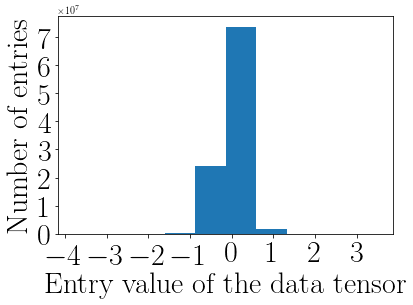

In [5]:
fontsize = 30
# ytick_pos = np.array([0, 2000, 4000, 6000, 8000])

plt.hist(X.flatten())
plt.ylabel("Number of entries", fontsize=fontsize)
plt.xlabel("Entry value of the data tensor", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000.]), <a list of 7 Text yticklabel objects>)

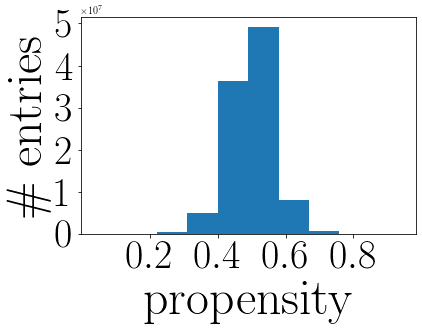

In [6]:
fontsize = 50
# ytick_pos = np.array([0, 2000, 4000, 6000, 8000])

plt.hist(P.flatten())
plt.ylabel("\# entries", fontsize=fontsize)
plt.xlabel("propensity", fontsize=fontsize)

xtick_pos = [0.2, 0.4, 0.6, 0.8]
plt.xticks(xtick_pos, fontsize=fontsize-10)
plt.yticks(fontsize=fontsize-10)

In [7]:
prop_B = std_logistic_function(A_true)
mask_B = (np.random.uniform(0, 1, prop_B.shape) < prop_B).astype(int)

In [8]:
A_sq = square_unfolding(A)
_, A_Sigma, _ = randomized_svd(A_sq, n_components=10, n_iter=20, random_state=None)
alpha_of_A_sq = np.max(np.abs(A_sq))
theta_of_A_sq = np.sum(A_Sigma) / (np.sqrt(np.prod(A_sq.shape)))

In [9]:
alpha_of_A_sq

3.1740064600780293

In [10]:
theta_of_A_sq

0.7183197378579977

In [11]:
def evaluate_sq(max_iter, fixed_step_size=False, tau_ratio=1, gamma_ratio=1):
    """
    A helper function to run Algorithm 1 with a specified configuration.
    """
    print("maximum iteration: {}".format(max_iter))
    
    prop_B_sq = square_unfolding(prop_B)
    mask_B_sq = square_unfolding(mask_B)

    start = time.time()
    A_sq_pred = one_bit_MC_fully_observed(mask_B_sq, std_logistic_function, 
                                          apg_max_iter=max_iter, tau=tau_ratio * theta_of_A_sq, 
                                          gamma=gamma_ratio * alpha_of_A_sq, max_rank=25, init='uniform', 
                                          fixed_step_size=fixed_step_size)
    elapsed = time.time() - start
    print("maximum iteration {} finished".format(max_iter))
    return deepcopy(max_iter), deepcopy(elapsed), deepcopy(A_sq_pred)

change tau

In [ ]:
tau_ratio_all = [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]

In [ ]:
p1 = mp.Pool(30)
result = [p1.apply_async(evaluate_sq, args=[10, True, tau_ratio, 1]) for tau_ratio in tau_ratio_all]
p1.close()
p1.join()

result = [item.get() for item in result]

In [ ]:
A_true_sq = square_unfolding(A_true)

In [ ]:
def extract_optimization_details(item):
    max_iter = item[0]
    elapsed = item[1]
    A_sq_pred = item[2]    

    loss = tensor_log_loss(square_unfolding(mask_X), A_sq_pred)
    _, A_pred_Sigma, _ = randomized_svd(A_sq_pred, n_components=5, n_iter=20, random_state=None)
    alpha_of_A_pred_sq = np.max(np.abs(A_sq_pred))
    theta_of_A_pred_sq = np.sum(A_pred_Sigma) / (np.sqrt(np.prod(A_sq_pred.shape)))     
    
    return max_iter, elapsed, normalized_error(A_true_sq, A_sq_pred), \
        normalized_error(std_logistic_function(A_true_sq), std_logistic_function(A_sq_pred)), \
        alpha_of_A_pred_sq, theta_of_A_pred_sq, loss
#     print("iter {}, elapsed time {}, A normalized error {:.4f}, P normalized error {:.4f}, alpha: {:.4f}, theta: {:.4f}".format(
#         ))

In [ ]:
p2 = mp.Pool(25)
result_extracted = [p2.apply_async(extract_optimization_details, args=[item]) for item in result]
p2.close()
p2.join()

In [ ]:
P_normalized_error_all = []
for idx, item in enumerate(result_extracted):
#     print(tau_ratio_all[idx])
#     print("iter {}, elapsed time {}, A normalized error {:.4f}, \
#     P normalized error {:.4f}, alpha: {:.4f}, theta: {:.4f}, loss: {:.4f}".format(*item.get()))
    P_normalized_error_all.append(item.get()[3])

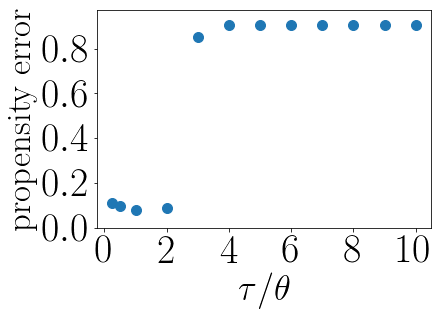

In [94]:
fontsize = 40
markersize = 100
plt.scatter(tau_ratio_all[:12], P_normalized_error_all[:12], s=markersize)
plt.ylabel("propensity error", fontsize=fontsize-5)
plt.xlabel(r'$\tau/\theta$', fontsize=fontsize-5)
ytick_pos = [0, 0.2, 0.4, 0.6, 0.8]
plt.xticks(fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)

change gamma

In [ ]:
gamma_ratio_all = [0.25, 0.5, 1, 2, 3, 4, 5, 8, 10]
p2 = mp.Pool(30)
result_2 = [p2.apply_async(evaluate_sq, args=[10, True, 1, gamma_ratio]) for gamma_ratio in gamma_ratio_all]
p2.close()
p2.join()

result_2 = [item.get() for item in result_2]

In [ ]:
p3 = mp.Pool(25)
result_2_extracted = [p3.apply_async(extract_optimization_details, args=[item]) for item in result_2]
p3.close()
p3.join()

In [ ]:
P_normalized_error_all_2 = []
for idx, item in enumerate(result_2_extracted):
    print(gamma_ratio_all[idx])
#     print("iter {}, elapsed time {}, A normalized error {:.4f}, \
#     P normalized error {:.4f}, alpha: {:.4f}, theta: {:.4f}, loss: {:.4f}".format(*item.get()))
    P_normalized_error_all_2.append(item.get()[3])

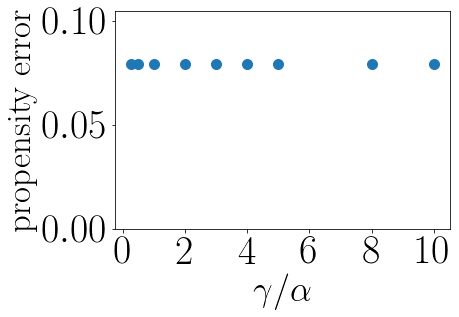

In [93]:
fontsize = 40
markersize = 100
plt.scatter(gamma_ratio_all, P_normalized_error_all_2, s=markersize)
plt.ylabel("propensity error", fontsize=fontsize-5)
plt.xlabel(r'$\gamma / \alpha$', fontsize=fontsize-5)
# xtick_pos = [0.2, 0.4, 0.6]
ytick_pos = [0, 0.05, 0.10]
plt.xticks(fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)